In [1]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2
import sys
import os
import glob
import requests
import datetime
import insar
from insar import *
from insar.blob import synthetic, scores
from insar.blob import utils as blob_utils
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import sqrt

In [2]:
shape = (100, 100)
finding_params = { 
    'positive': True, 
    'negative': True, 
    'threshold': 0.35, 
    'mag_threshold': None, 
    'min_sigma': 3, 
    'max_sigma': 140, 
    'num_sigma': 90, 
    'sigma_bins': 3, 
    'log_scale': False,
} 


### Finding edges/ corners

<IPython.core.display.Javascript object>


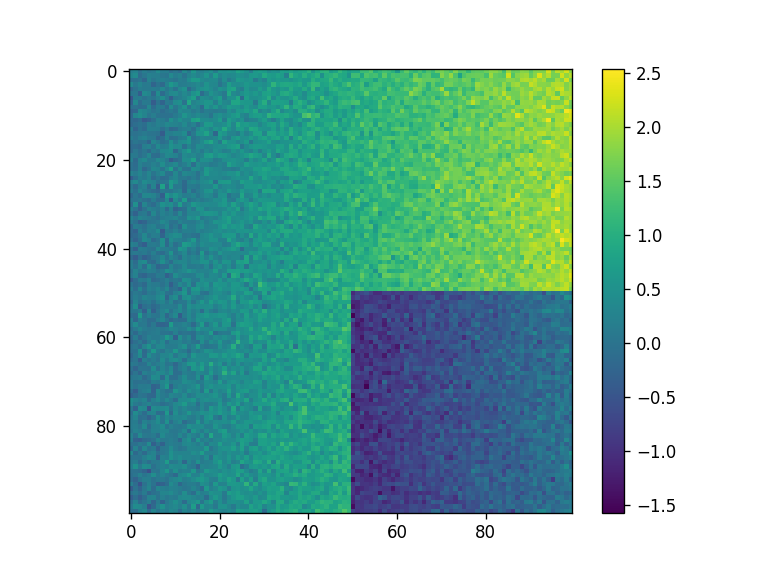

In [3]:
edge = synthetic.make_edge(shape, jump=-2) 
def plot_one(img, **kwargs):
    fig, ax = plt.subplots()
    axim = ax.imshow(img, **kwargs)
    fig.colorbar(axim)

plot_one(edge)

#### Without checking curvature:

<IPython.core.display.Javascript object>


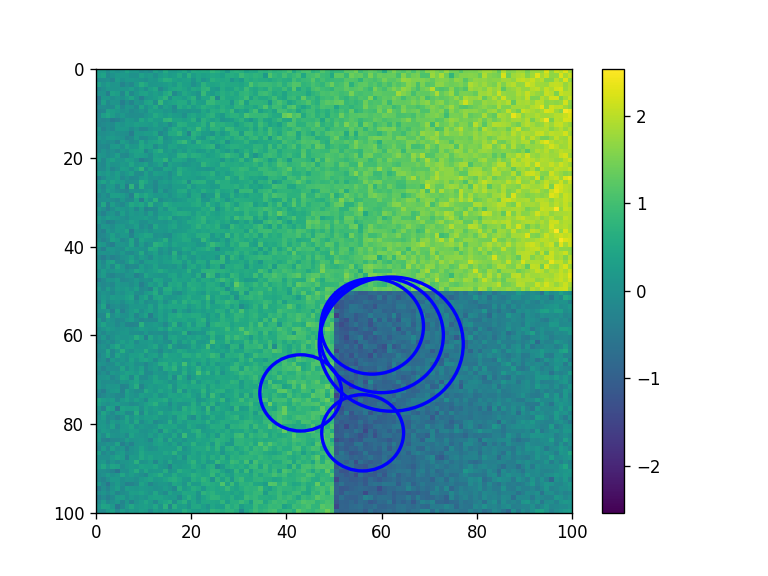

(array([[73.        , 43.        ,  8.59651165,  1.35854163],
        [62.        , 62.        , 15.12731811, -1.57034503],
        [58.        , 58.        , 10.77344714, -1.56633555],
        [60.        , 60.        , 12.95038262, -1.56633555],
        [82.        , 56.        ,  8.59651165, -1.4337117 ]]),
 <matplotlib.axes._subplots.AxesSubplot at 0x7f43133796a0>)

In [4]:
blobs_edge, sigma_list = blob.find_blobs(edge, **finding_params, bowl_score=0)
blob.plot.plot_blobs(image=edge, blobs=blobs_edge, cmap='viridis', perform_shift=False)

#### With curvature check

Removing blobs with bowl scores under 0.625
removing blob: [73 43  8  1], score: 0.5207199827194716
removing blob: [82 56  8 -1], score: -0.5164263023388233


<IPython.core.display.Javascript object>


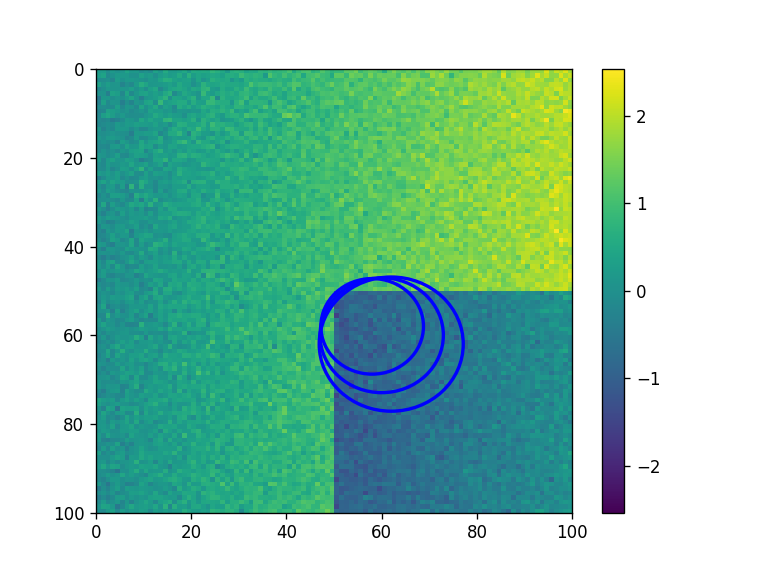

(array([[62.        , 62.        , 15.12731811, -1.57034503],
        [58.        , 58.        , 10.77344714, -1.56633555],
        [60.        , 60.        , 12.95038262, -1.56633555]]),
 <matplotlib.axes._subplots.AxesSubplot at 0x7f431330e048>)

In [5]:
blobs_edge, sigma_list = blob.find_blobs(edge, **finding_params, bowl_score=5/8)
blob.plot.plot_blobs(image=edge, blobs=blobs_edge, cmap='viridis', perform_shift=False)

The corner discontinuity still appears as a blob due to the ramp upward

<IPython.core.display.Javascript object>


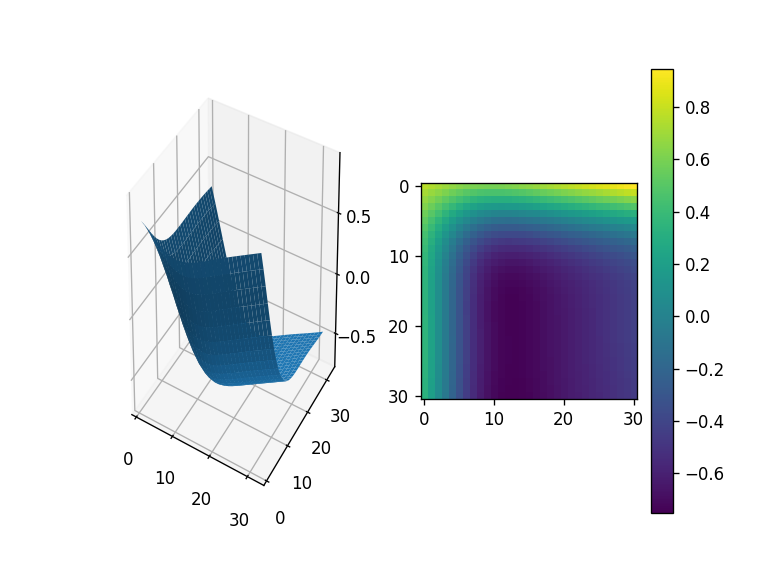

In [6]:
 blob.plot.plot_cropped_blob(image=edge, blob=blobs_edge[0], sigma=5)

#### What does the curvature look like on this patch?

<IPython.core.display.Javascript object>


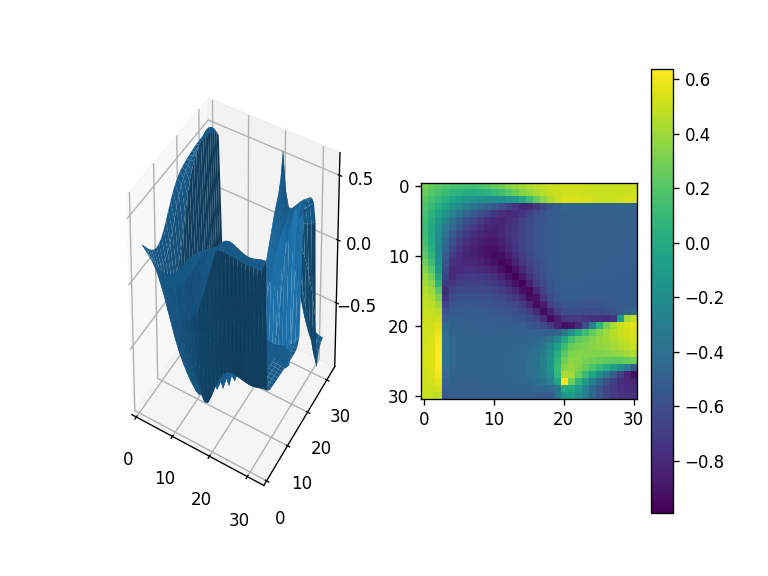

In [7]:
blob.plot.plot_cropped_blob(blob.skblob.shape_index(edge, sigma=5), blobs_edge[0])

So maybe either

- check if there is a large jump anywhere in the shape index
- (Normalize first?) check if there are huge jumps in the gradient of the image itself

In [8]:
scores.max_gradient(blob.utils.gaussian_filter(edge, sigma=4))
scores.max_gradient(blob.skblob.shape_index(edge, sigma=5))

1.5850704233121675

5.043074811284747

## 2 Blob Examples

0: equal strength blobs, equal size

1. strong, big up touching smaller up (peak gets overwhelmed, looks like ramp up to stronger)
2. small, strong uplift touching medium-strong big (make bigger looks like edge?)
3. medium, big up touching smaller strong down
4. medium, big up touching smaller, weaker down
5. 3 strong uplift making a circle (can't tell difference)
6. see case 6 saved
7. see case 7 saved


In [9]:
shape = (200, 200)
FIGSIZE = (9, 4)

def two_blob(shape, amp1, sigma1, amp2, sigma2, dist_ratio=None, dist=None, noise_sigma=0.5):    
    rows, cols = shape
    if dist:
        col2 = int(cols // 2 + dist)
    elif dist_ratio is not None:
        col2 = int(cols // 2 + dist_ratio * cols)
    else:
        raise ValueError("Need dist or dist_ratio")
        
    out = synthetic.make_gaussian(shape=shape, sigma=sigma1, amp=amp1)
    out += synthetic.make_gaussian(shape=shape, sigma=sigma2, amp=amp2, col=col2)
    out += synthetic.make_noise(shape, sigma=noise_sigma)
    return out

def make_two_blob_arr(shape, amp1, sigma1, amp2, sigma2, dist_arr, noise_sigma=0.5):
    return [two_blob(shape, amp1, sigma1, amp2, sigma2, noise_sigma=noise_sigma, dist=d) for d in dist_arr]
    

def plot_blob_arr(out_array, dist_arr, nrows=None, ncols=None, cmap='viridis', bowl_score=0, figsize=FIGSIZE):
    if not nrows or not ncols:
        ncols = len(out_array)
        nrows = 1
        
    # Squeeze makes it always return an ndarray
    fig, axes = plt.subplots(nrows, ncols, figsize=figsize, squeeze=False)
    
    all_blobs = []

    for idx, ax in enumerate(axes.ravel()):
        img = out_array[idx]
        dist = dist_arr[idx]
        blobs, _ = blob.find_blobs(img, **finding_params, bowl_score=bowl_score)
        blob.plot.plot_blobs(image=img, blobs=blobs, fig=fig, ax=ax, cmap=cmap,
                             plot_img=True, perform_shift=False, title='dist=%s' % dist)
        all_blobs.append(blobs)
        
    return all_blobs

#### Case 0: equal strength blobs, equal size
They both remain detectable as the slowly cancel each other out (see colorbar scale differences)

<IPython.core.display.Javascript object>


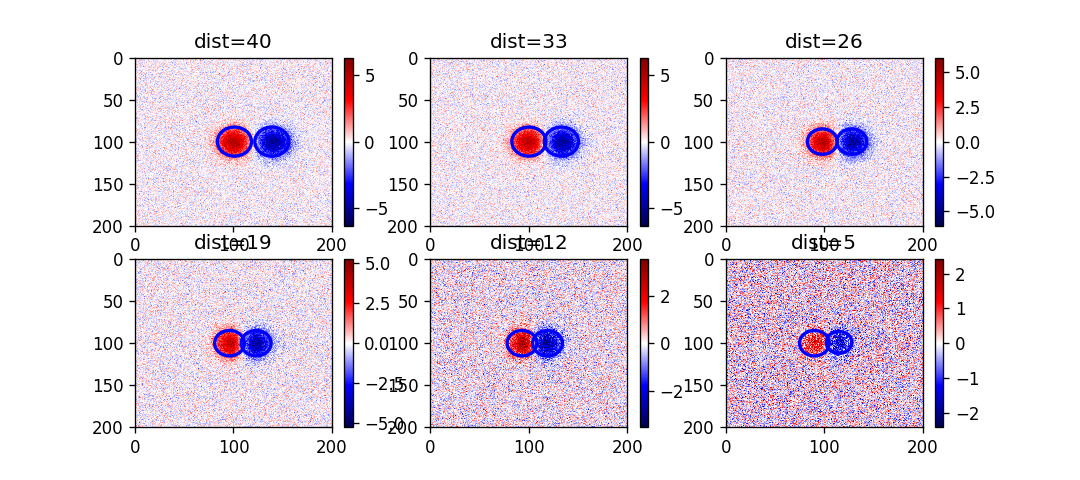

Removing blobs with bowl scores under 0.625
Removing blobs with bowl scores under 0.625
Removing blobs with bowl scores under 0.625
Removing blobs with bowl scores under 0.625
Removing blobs with bowl scores under 0.625
Removing blobs with bowl scores under 0.625


In [10]:
amp1, sigma1 = (5, 12)
amp2, sigma2 = (-5, 12)
noise_sigma = 0.5

rows = 2
cols = 3
dist_arr = [40 - idx*7 for idx in range(rows*cols)]

img_array = make_two_blob_arr(shape, amp1, sigma1, amp2, sigma2, dist_arr, noise_sigma=noise_sigma)
all_blobs = plot_blob_arr(img_array, dist_arr, nrows=rows, ncols=cols, cmap='seismic', bowl_score=5/8)


<IPython.core.display.Javascript object>


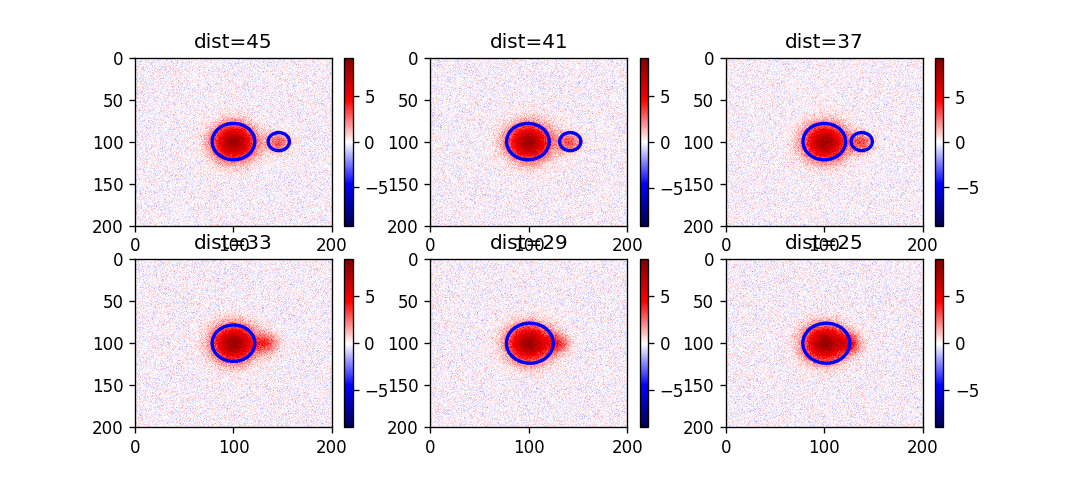

Removing blobs with bowl scores under 0.625
Removing blobs with bowl scores under 0.625
Removing blobs with bowl scores under 0.625
Removing blobs with bowl scores under 0.625
removing blob: [176 109  47  -1], score: 0.10334139310041153
Removing blobs with bowl scores under 0.625
Removing blobs with bowl scores under 0.625


In [11]:
amp1, sigma1 = (8, 15)  # Strong, wide
amp2, sigma2 = (3, 8)  # Weaker, smaller
noise_sigma = 0.5

rows = 2
cols = 3
dist_arr = [45 - idx*4 for idx in range(rows*cols)]

img_array = make_two_blob_arr(shape, amp1, sigma1, amp2, sigma2, dist_arr, noise_sigma=noise_sigma)
all_blobs = plot_blob_arr(img_array, dist_arr, nrows=rows, ncols=cols, cmap='seismic', bowl_score=5/8)


#### Case 2
strong, big up touching stronger small, also up

<IPython.core.display.Javascript object>


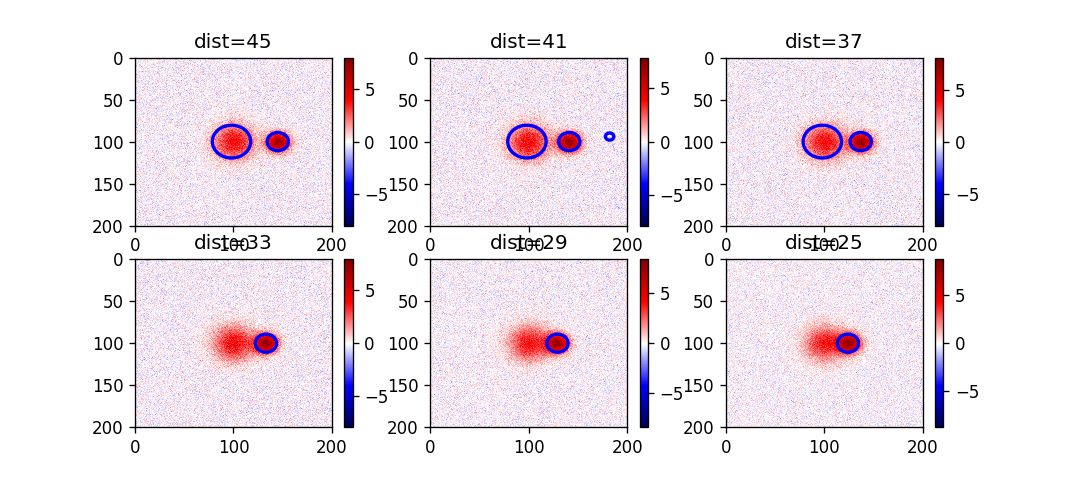

Removing blobs with bowl scores under 0.625
Removing blobs with bowl scores under 0.625
Removing blobs with bowl scores under 0.625
removing blob: [100 117  30   8], score: 0.5627716042022585
removing blob: [120 151  12  -1], score: -0.3230550093304101
Removing blobs with bowl scores under 0.625
Removing blobs with bowl scores under 0.625
Removing blobs with bowl scores under 0.625


In [12]:
amp1, sigma1 = (4, 15)
amp2, sigma2 = (7, 8)
noise_sigma = 0.5

rows = 2
cols = 3
dist_arr = [45 - idx*4 for idx in range(rows*cols)]

img_array = make_two_blob_arr(shape, amp1, sigma1, amp2, sigma2, dist_arr, noise_sigma=noise_sigma)
all_blobs = plot_blob_arr(img_array, dist_arr, nrows=rows, ncols=cols, cmap='seismic', bowl_score=5/8)


#### Case 3: medium, big up touching smaller, stronger down


<IPython.core.display.Javascript object>


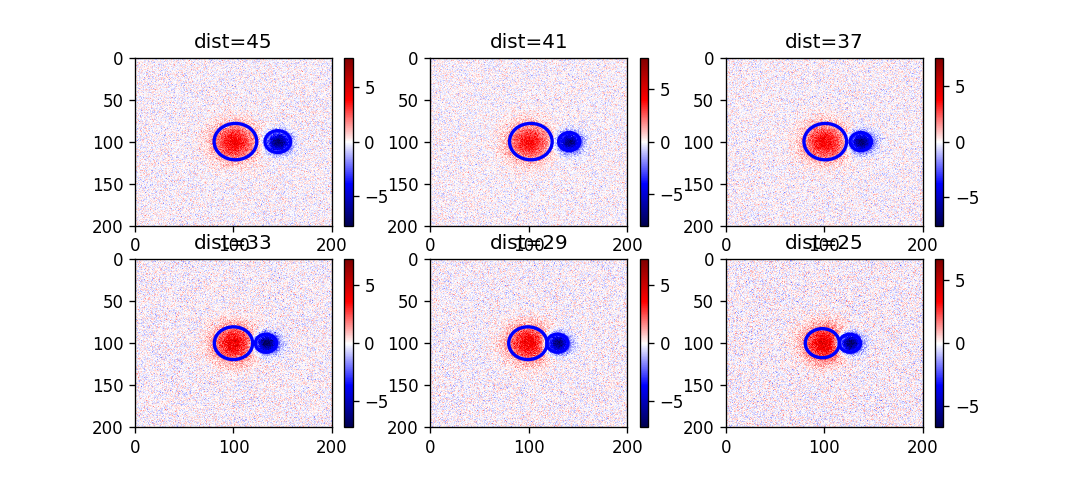

Removing blobs with bowl scores under 0.625
Removing blobs with bowl scores under 0.625
Removing blobs with bowl scores under 0.625
Removing blobs with bowl scores under 0.625
Removing blobs with bowl scores under 0.625
Removing blobs with bowl scores under 0.625


In [13]:
amp1, sigma1 = (4, 15)
amp2, sigma2 = (-7, 8)
noise_sigma = 0.5

rows = 2
cols = 3
dist_arr = [45 - idx*4 for idx in range(rows*cols)]

img_array = make_two_blob_arr(shape, amp1, sigma1, amp2, sigma2, dist_arr, noise_sigma=noise_sigma)
all_blobs = plot_blob_arr(img_array, dist_arr, nrows=rows, ncols=cols, cmap='seismic', bowl_score=5/8)


#### Case 4: medium, big up touching smaller, weaker down

This one is more resilient to overlapping

<IPython.core.display.Javascript object>


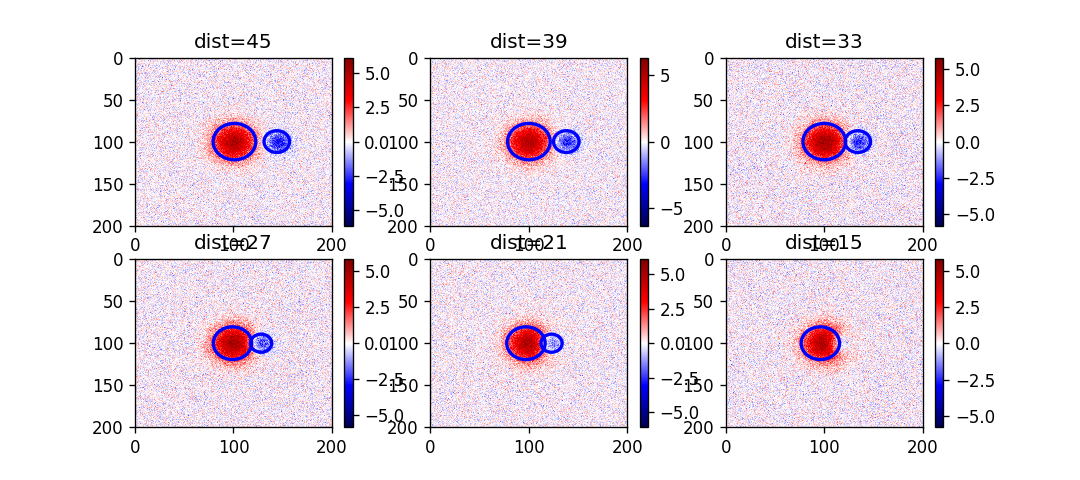

Removing blobs with bowl scores under 0.625
removing blob: [138  85  19  -1], score: -0.32031302847994714
Removing blobs with bowl scores under 0.625
Removing blobs with bowl scores under 0.625
Removing blobs with bowl scores under 0.625
Removing blobs with bowl scores under 0.625
Removing blobs with bowl scores under 0.625


In [14]:
amp1, sigma1 = (5, 15)
amp2, sigma2 = (-3, 8)
noise_sigma = 0.5

rows = 2
cols = 3
dist_arr = [45 - idx*6 for idx in range(rows*cols)]

img_array = make_two_blob_arr(shape, amp1, sigma1, amp2, sigma2, dist_arr, noise_sigma=noise_sigma)
all_blobs = plot_blob_arr(img_array, dist_arr, nrows=rows, ncols=cols, cmap='seismic', bowl_score=5/8)


#### Case 5: 3 strong uplift making a circle 

We can't tell difference in an obvious way between this an a subsidence in the middle

Note that the outer, bigger blob is not the same mistake: this is from blurring the 3 uplifts to seem like a larger uplift (desired behavior)

<IPython.core.display.Javascript object>


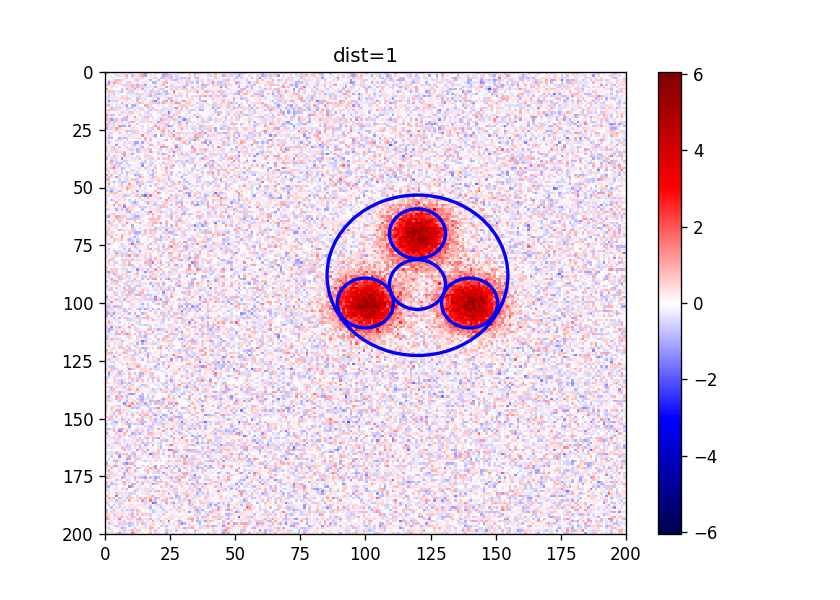

Removing blobs with bowl scores under 0.625
[array([[ 88.        , 120.        ,  34.71973746,   6.0497146 ],
       [100.        , 100.        ,  10.77344714,   6.0497146 ],
       [ 70.        , 120.        ,  10.77344714,   5.98046819],
       [100.        , 140.        ,  10.77344714,   5.82938164],
       [ 92.        , 120.        ,  10.77344714,  -0.74276957]])]


In [15]:
amp1, sigma1 = (5, 8)
amp2, sigma2 = (5, 8)
amp3, sigma3 = (5, 8)
noise_sigma = 0.5

# dist_arr = [45 - idx*6 for idx in range(rows*cols)]

triple = synthetic.make_gaussian(shape=shape, sigma=sigma1, amp=amp1)
triple += synthetic.make_gaussian(shape=shape, sigma=sigma2, amp=amp2, row=70, col=120)
triple += synthetic.make_gaussian(shape=shape, sigma=sigma3, amp=amp3, row=100, col=140)
triple += synthetic.make_noise(shape, sigma=noise_sigma)


rows = 1
cols = 1
# fig, ax = plt.subplots(rows, cols, squeeze=False)
# ax.imshow(out)

# img_array = make_two_blob_arr(shape, amp1, sigma1, amp2, sigma2, dist_arr, noise_sigma=noise_sigma)
all_blobs = plot_blob_arr([triple], [1], nrows=rows, ncols=cols, cmap='seismic', bowl_score=5/8, figsize=(7, 5))
print(all_blobs)

<IPython.core.display.Javascript object>


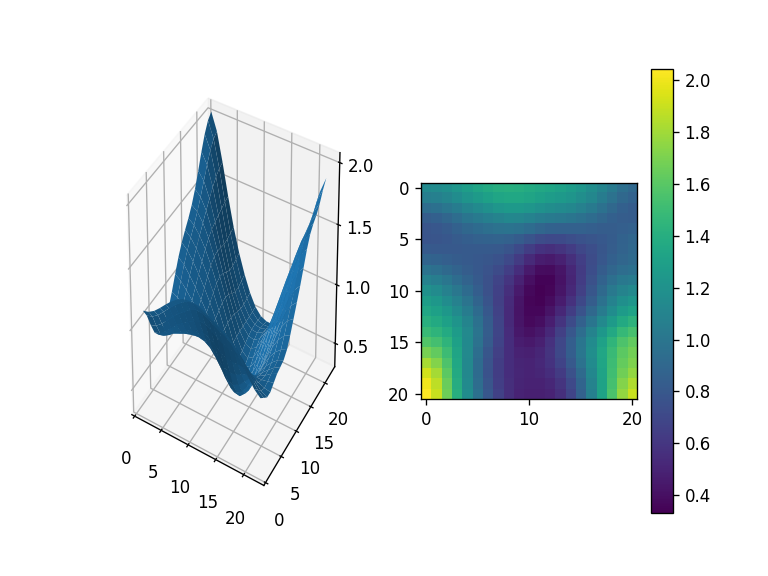

<IPython.core.display.Javascript object>


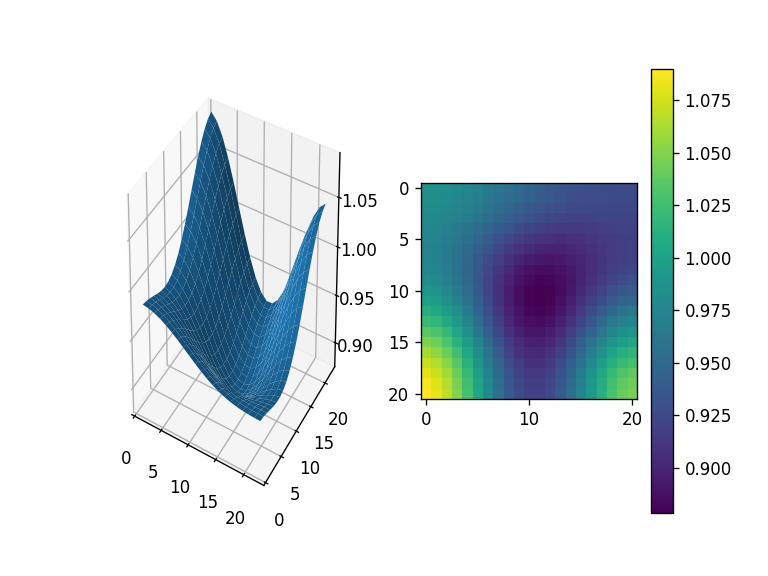

In [16]:
mistake = all_blobs[0][-1]
triple_patch = blob_utils.crop_blob(image=triple, blob=all_blobs[0][-1])
blob.plot.plot_cropped_blob(patch=triple_patch, sigma=2)
blob.plot.plot_cropped_blob(patch=triple_patch, sigma=7)

So only with a small noise filter (sigma=2) can we still even tell this isn't a legitimate subsidence

What is the curvature on this section? With more 

<IPython.core.display.Javascript object>


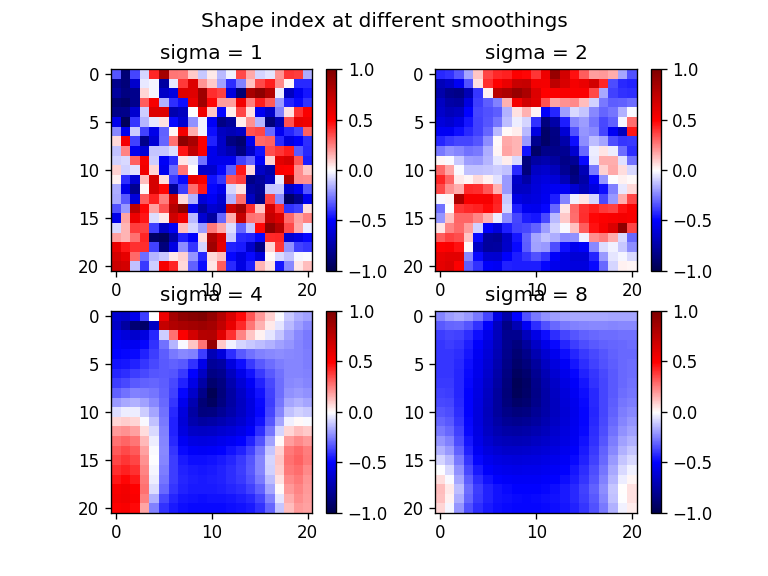

(<Figure size 640x480 with 8 Axes>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f43123ec898>,
       dtype=object))

In [17]:
def plot_shape_index_vs_sigmas(patch, sigmas, nrows=None, ncols=None):
    if not nrows or not ncols:
        ncols = len(sigmas)
        nrows = 1
        
    fig, axes = plt.subplots(nrows, ncols, squeeze=False)
    
    for ax, sigma in zip(axes.ravel(), sigmas):
        axim = ax.imshow(blob.skblob.shape_index(patch, sigma=sigma, mode='nearest'),
                         vmin=-1, vmax=1, cmap='seismic')
        ax.set_title('sigma = %s' % sigma);
        fig.colorbar(axim, ax=ax);
    fig.suptitle("Shape index at different smoothings");
    return fig, axes

    
sigmas = [1, 2, 4, 8]
plot_shape_index_vs_sigmas(triple_patch, sigmas, 2, 2)
    


In [18]:
# blob.find_blobs(img_array[0], **finding_params, bowl_score=.6)
# blob.plot.plot_cropped_blob(image=img_array[0], blob=all_blobs[0][-1], sigma=2)
# fig, axes = plt.subplots(1, 2)
# axes[0].imshow(patch)
# axes[1].imshow(triple_patch)


#### Case 6: weird case study of a distorted subsidence

<IPython.core.display.Javascript object>


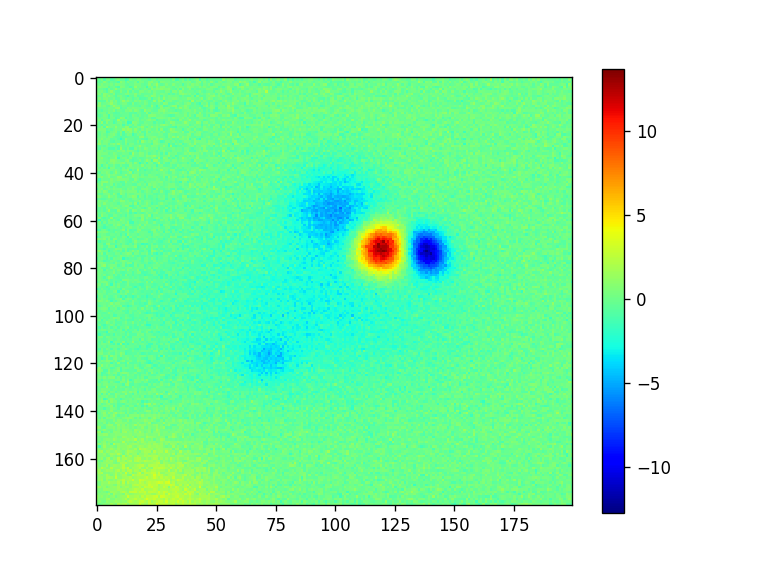

In [19]:
image = np.load('synth_case6.npy')
plot_one(image, cmap='jet')

#### First find blobs while checking for the bowl score

Removing blobs with bowl scores under 0.625
removing blob: [55 99 15 -6], score: -0.6047230365077241


<IPython.core.display.Javascript object>


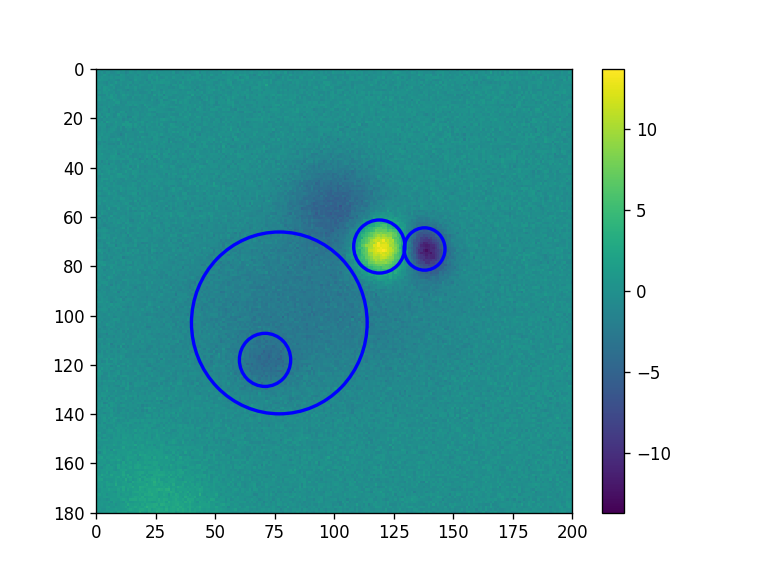

(array([[ 72.        , 119.        ,  10.77344714,  13.66967089],
        [ 73.        , 138.        ,   8.59651165, -12.69446684],
        [118.        ,  71.        ,  10.77344714,  -5.26444345],
        [103.        ,  77.        ,  36.89667294,  -5.26444345]]),
 <matplotlib.axes._subplots.AxesSubplot at 0x7f43121e8940>)

In [20]:
blobs, sigma_list = blob.find_blobs(image, **finding_params, bowl_score=5/8)
blob.plot.plot_blobs(image=image, blobs=blobs, cmap='viridis', perform_shift=False)

#### Now without checking the bowl score

<IPython.core.display.Javascript object>


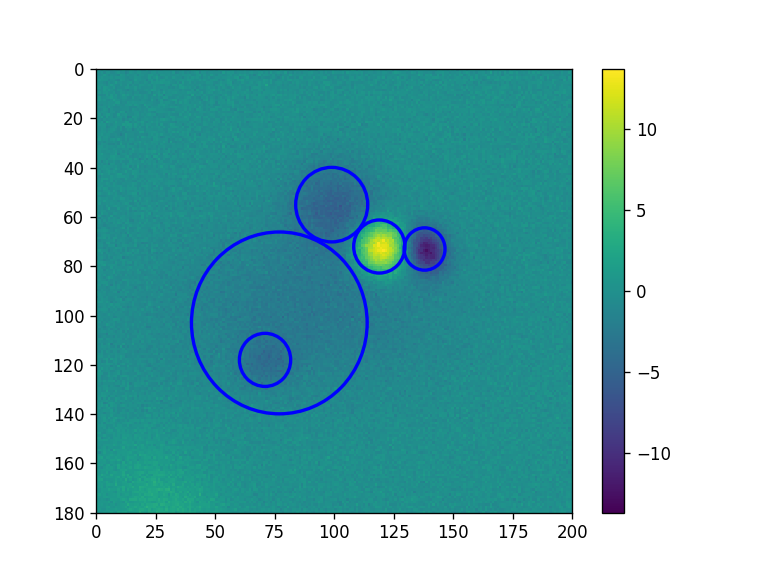

(array([[ 72.        , 119.        ,  10.77344714,  13.66967089],
        [ 73.        , 138.        ,   8.59651165, -12.69446684],
        [ 55.        ,  99.        ,  15.12731811,  -6.64091597],
        [118.        ,  71.        ,  10.77344714,  -5.26444345],
        [103.        ,  77.        ,  36.89667294,  -5.26444345]]),
 <matplotlib.axes._subplots.AxesSubplot at 0x7f43121b5588>)

In [21]:
blobs, sigma_list = blob.find_blobs(image, **finding_params, bowl_score=0)
blob.plot.plot_blobs(image=image, blobs=blobs, cmap='viridis', perform_shift=False)

#### Why is the bowl score not great?
It is close to good, but more like a valley than a bowl

<IPython.core.display.Javascript object>


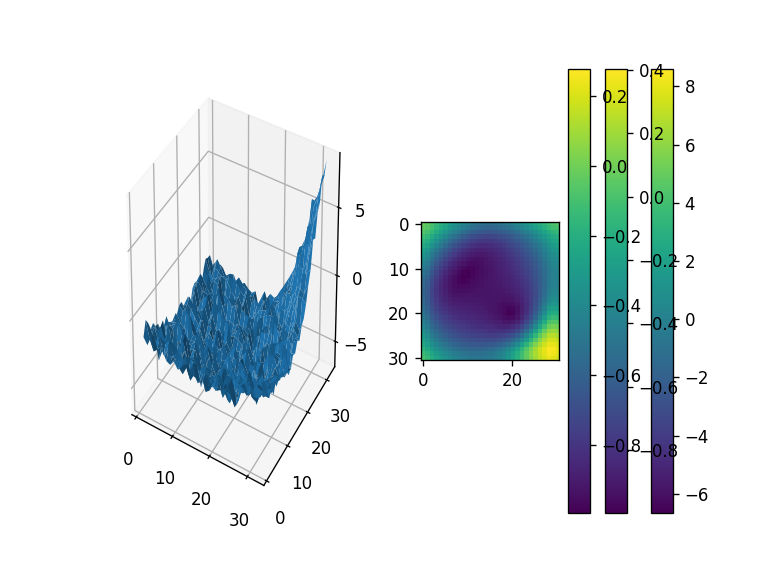

-0.6077244704884331
psize 3
-0.6077244704884331


In [22]:
missing = blobs[2]
patch = blob_utils.crop_blob(image, missing, crop_val=None)
blob.plot.plot_cropped_blob(patch=patch)
print(blob.get_blob_bowl_score(image, missing, sigma=15/sqrt(2)))
print(scores.shape_index_center(patch, patch_size=3, sigma=15/sqrt(2)))

The shape score of -.604 is very close to the "trough" score, but falls

In [23]:
plt.imshow(blob.skblob.shape_index(patch, sigma=11, mode='nearest'))
plt.colorbar()

In [24]:
plt.imshow(blob.skblob.shape_index(patch, sigma=11, mode='constant'))
plt.colorbar()

# Demo runs:

<IPython.core.display.Javascript object>


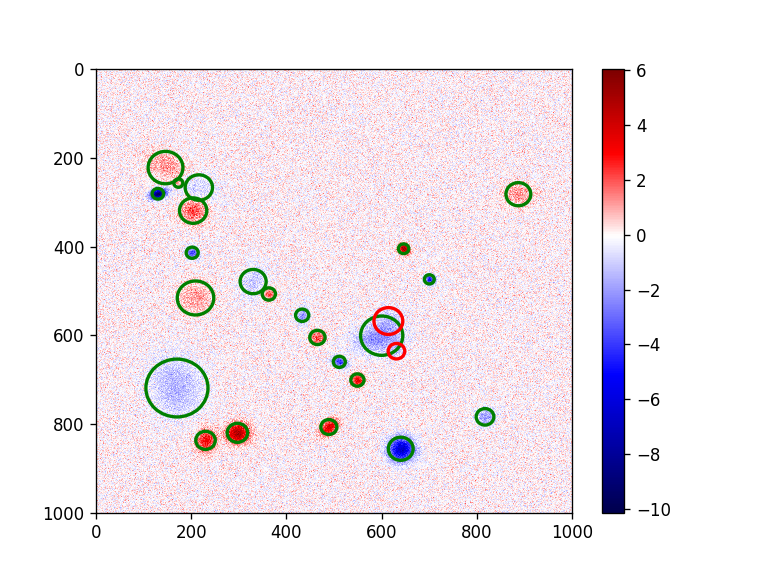

In [25]:
synthetic.plot_run_summary(synthetic.load_run(3, '../../patches3'))

<IPython.core.display.Javascript object>


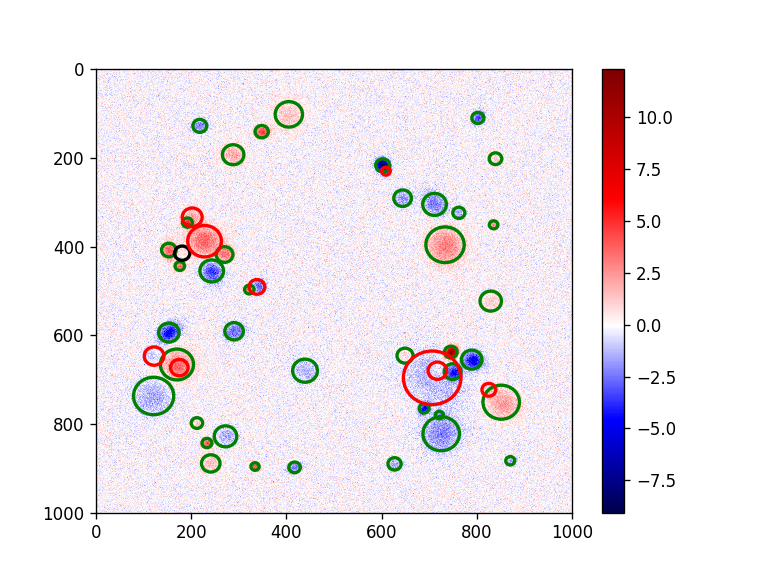

In [26]:
synthetic.plot_run_summary(synthetic.load_run(4, '../../patches3'))

/home/scott/envs/data/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


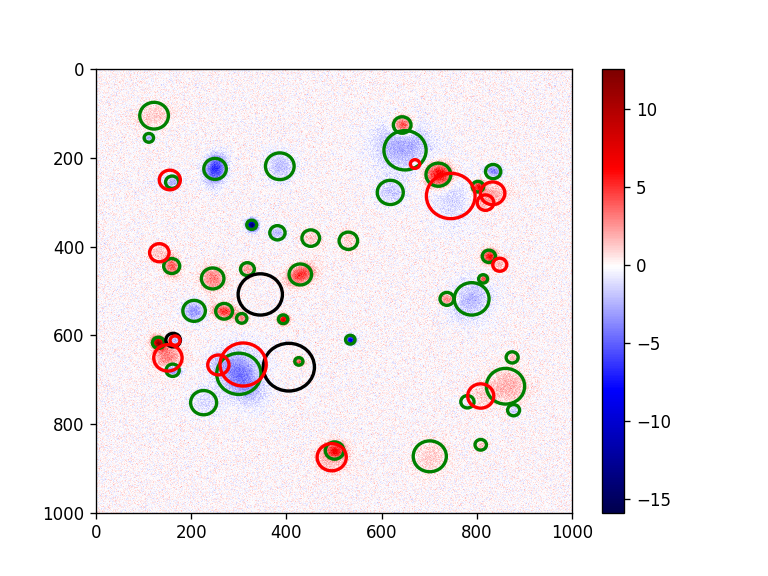

In [27]:
synthetic.plot_run_summary(synthetic.load_run(5, '../../patches3'))

<IPython.core.display.Javascript object>


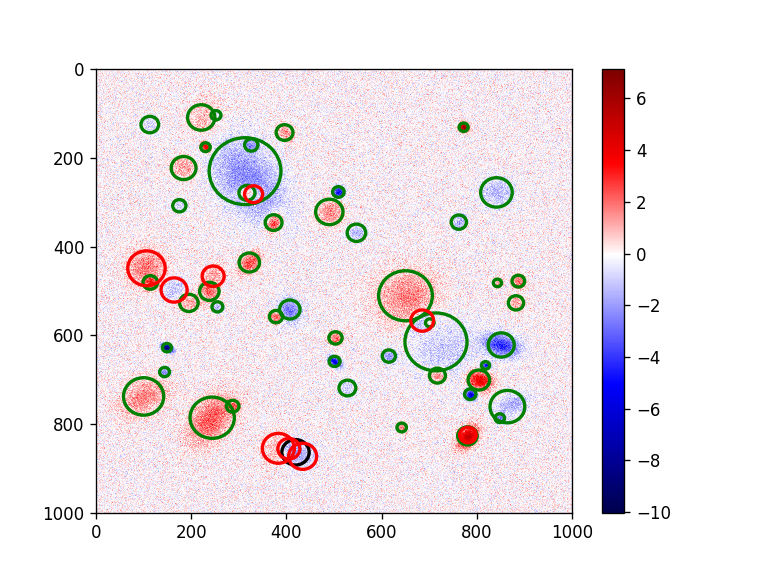

In [28]:
synthetic.plot_run_summary(synthetic.load_run(6, '../../patches3'))

<IPython.core.display.Javascript object>


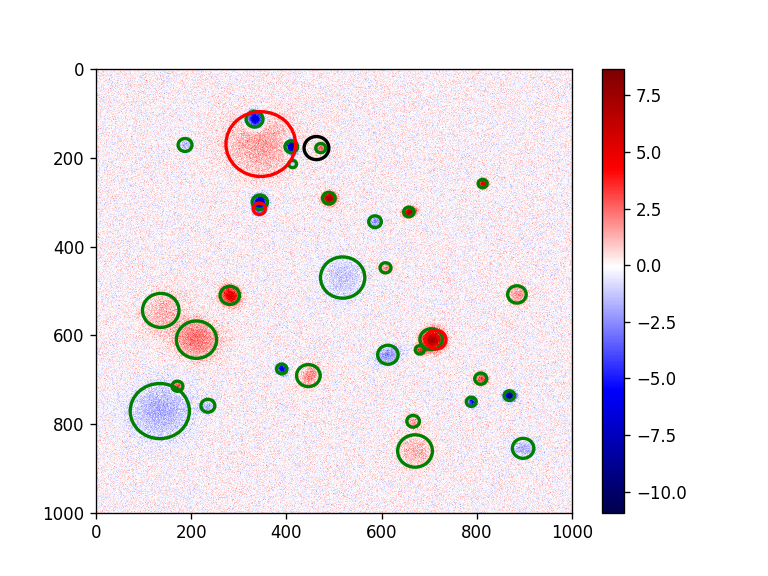

In [29]:
synthetic.plot_run_summary(synthetic.load_run(7, '../../patches3'))